[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/tarea2-cnn-recurrentes-transferencia/1_convolucion.ipynb)

# Operación de convolución
Daniel Alejandro Alonso Bastos

Extiende la operación de convolución para imágenes en escala de grises (un solo canal) vista en [clase](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2a_convolucion.ipynb) a imágenes a color (múltiples canales).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image

A continuación se cargan un par de imágenes en RGB de la paquetería `scikit-learn` para usarlas como ejemplo:


Img shape: (427, 640, 3), Img type: uint8 



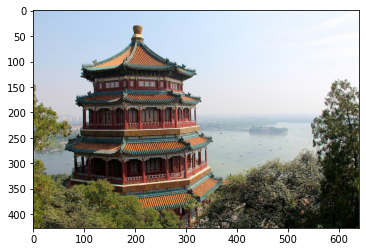

In [2]:
img1 = load_sample_image('china.jpg')
print(f'Img shape: {img1.shape}, Img type: {img1.dtype} \n')
plt.imshow(img1)
plt.show()

Img shape: (427, 640, 3), Img type: uint8 



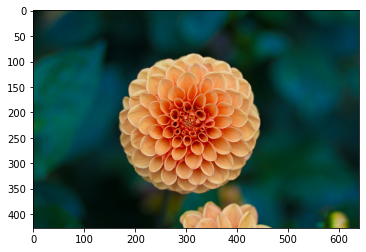

In [3]:
img2 = load_sample_image('flower.jpg')
print(f'Img shape: {img2.shape}, Img type: {img2.dtype} \n')
plt.imshow(img2)
plt.show()

Normalizar los valores para que se encuentren en el mismo rango $(0-255) → (0,1)$

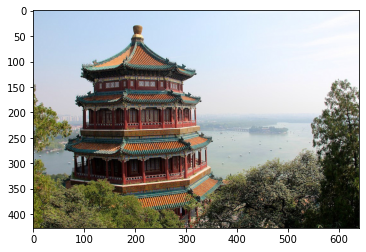

In [4]:
img1 = img1 / img1.max()
img2 = img2 / img2.max()
plt.imshow(img1)
plt.show()

## Convolución y correlación cruzada

La operación de convolución entre una imagen $I$ y un filtro $K$, está definida por:

$$
A_{i,j} = (\mathbf{I} * \mathbf{K})_{i,j} = \sum_m \sum_n I_{m, n} K_{i - m, j - n}
$$

La convolución es commutativa, por lo tanto 

$$
A_{i,j} = (\mathbf{K} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i - m, j - n} K_{m,n}
$$

En lugar de la convolución, frecuentemente se ocupa la operación de correlación cruzada para llevar a cabo las capas convolucionales. Esta operación es similar a la convolución pero sin voltear el filtro (por lo que pierde la propiedad de conmutatividad) y está dada por

$$
A_{i,j} = (\mathbf{K} * \mathbf{I})_{i,j} = \sum_m \sum_n I_{i + m, j + n} K_{m,n} 
$$

El resultado de estas operaciones es el mapa de activaciones $A(i,j)$. 

Para realizar la convolución en una imagen con 3 canales, se aplica la convolución canal por canal tanto de la imagen como del filtro, y los canales resultantes se suman, produciendo un solo mapa de caracteríticas.

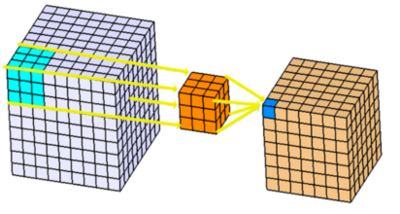

In [5]:
def conv3d(I, K, b, stride=1, padding=0, verbose=False):
  # tamaño de la imagen de entraada
  h_e, w_e, channels_e = I.shape
  # tamaño del filtro
  h_k, w_k, channels_k = K.shape

  # tamaño de la imagen de salida
  h_s = int(np.floor((h_e - h_k + 2*padding) / stride)) + 1 # height
  w_s = int(np.floor((w_e - w_k + 2*padding) / stride)) + 1 # width
  A = np.zeros((h_s, w_s)) # inicializacion de la matriz A

  #for channel in range(channels_e): # iterar sobre cada canal
  for i in range(h_s):
    for j in range(w_s):
      # tomar el cubo para realizar la convolucion
      I_m = I[i * stride:i * stride + h_k, j * stride:j * stride + w_k, :]
      # aplicar convolucion multiplicando el cubo con el filtro y agregar sesgo
      A[i,j] = (I_m * K).sum() + b
  
  if verbose:
    print(f'Tamaño de entrada: {I.shape} -> Tamaño de salida: {A.shape}')

  return A

## Filtros

A continuación se definen una serie de filtros: identidad, detección de bordes, _sharpen_ y _blur_. 

In [6]:
k_size = 3 # tamaño del kernel
k_channels = 3 # numero de canales del kernel

# identidad
f_identity = np.array([[[1,0,0],[0,1,0],[0,0,1]]]*k_channels)
# deteccion de bordes
f_edges = np.array([[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]]*k_channels)
# bordes horizontal
f_horizontal = np.array([[[0,0,0],[1,1,1],[0,0,0]]]*k_channels)
# bordes vericales
f_vertical = np.array([[[0,1,0],[0,1,0],[0,1,0]]]*k_channels)
# blur
f_blur = (1/k_size**2) * np.ones((k_size, k_size, k_channels))

# listas con los filtros
kernels = [f_identity, f_horizontal, f_vertical, f_edges, f_blur]

b = np.zeros(len(kernels))

La siguiente función aplica cada uno de los distintos filtros descritos, tal que el número de mapas de activaciones por imagen sería igual al número de filtros, que en este caso son 5.

In [7]:
def multi_conv3d(I, kernels, b, stride=1, padding = 0, verbose = False):
  # numero de filtros
  activations = []
  #for kernel, i in enumerate(kernels):
  #  activations.append(conv3d(I, kernel, b[i], stride, padding))
  for i in range(len(kernels)):
    activations.append(conv3d(I, kernels[i], b[i], stride, padding, verbose))
  
  return np.array(activations)

Al aplicar dicha función, se obtienen de cada imagen 5 mapas de activaciones. Además se imprime para ver el tamaño de entrada de la imagen, la cual tiene 3 canales y el tamño resultante de la convolución, la cual disminuye su resolución y solo tiene 1 canal.

In [8]:
activations_1 = np.tanh(multi_conv3d(img1, kernels, b, verbose = True))
activations_2 = np.tanh(multi_conv3d(img2, kernels, b))

Tamaño de entrada: (427, 640, 3) -> Tamaño de salida: (425, 638)
Tamaño de entrada: (427, 640, 3) -> Tamaño de salida: (425, 638)
Tamaño de entrada: (427, 640, 3) -> Tamaño de salida: (425, 638)
Tamaño de entrada: (427, 640, 3) -> Tamaño de salida: (425, 638)
Tamaño de entrada: (427, 640, 3) -> Tamaño de salida: (425, 638)


A continuación se grafica cada mapa de características de cada imagen.

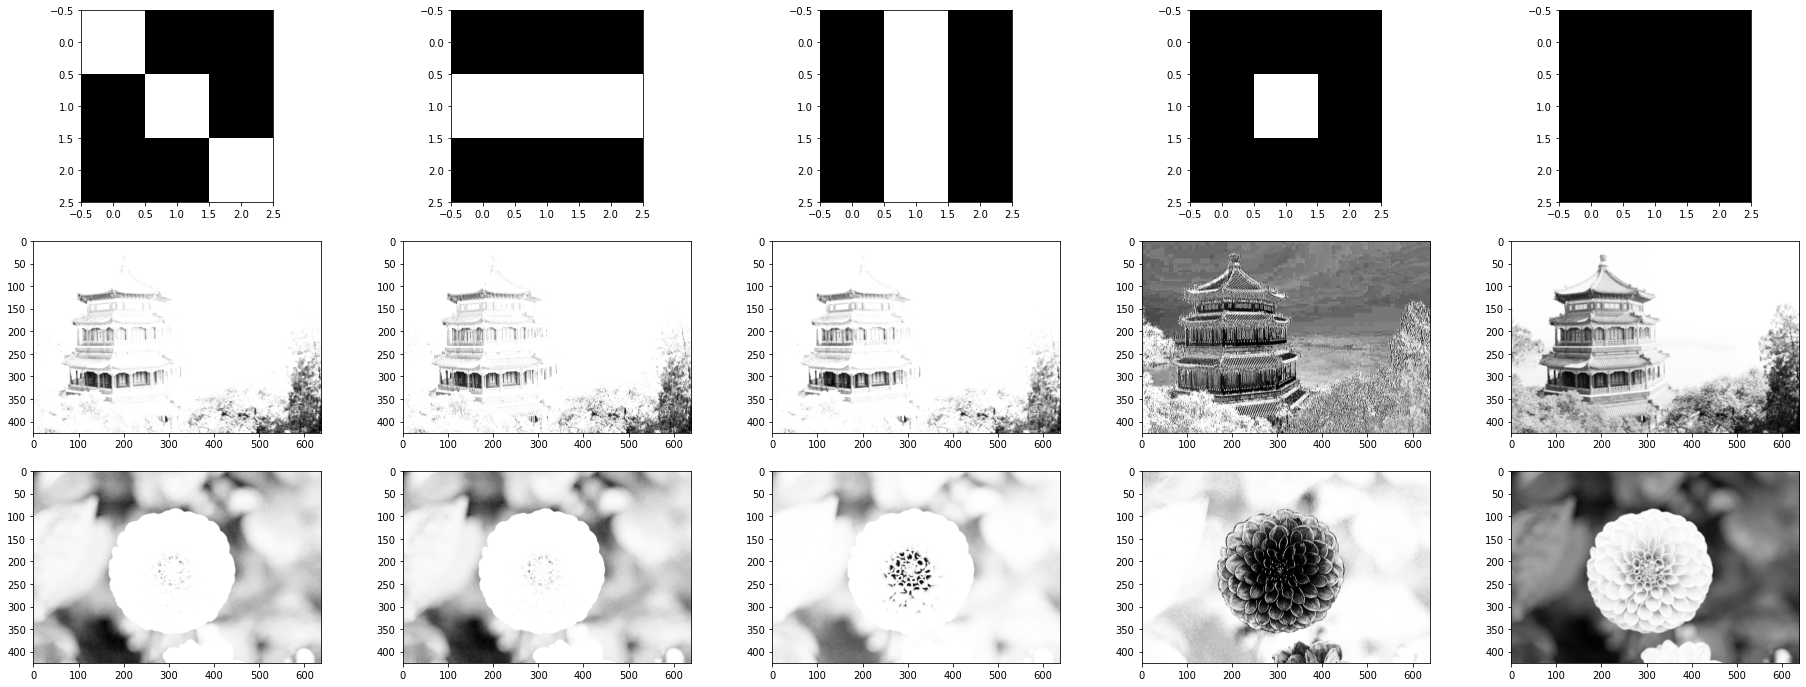

In [9]:
fig, ax = plt.subplots(3, len(kernels),figsize=(32, 12))
for i in range(len(kernels)):
  ax[0,i].imshow(kernels[i][0], cmap='gray')
  ax[1,i].imshow(activations_1[i], cmap='gray')
  ax[2,i].imshow(activations_2[i], cmap='gray')

plt.show()